Name: Varsha Kini

USC ID: 4013488464


Github Username: Varsha-Kini

In [2]:
import pandas as pd
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
import datetime
from tensorflow.keras import layers
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras import backend as K
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from keras.applications.vgg16 import VGG16, preprocess_input


In [7]:
data_directory = "/content/drive/MyDrive/Data/images"

In [4]:
!pip install split_folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
# Reference: https://pypi.org/project/split-folders/
import splitfolders 
output = "/content/drive/MyDrive/Data" 

splitfolders.ratio(data_directory, output=output, seed=1337, ratio=(0.715,0.16,0.125))

Copying files: 1176 files [06:55,  2.83 files/s]


VGG-16 Model

In [10]:
# Reference: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# Reference: https://www.kaggle.com/code/sriharipramod/loading-images-multiclass-image-classification
train_datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True,
    vertical_flip = True,
    preprocessing_function=preprocess_input
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_ds = train_datagen.flow_from_directory(
  "/content/drive/MyDrive/Data/train", 
  seed=1,
  target_size=(256, 256), 
  batch_size=5,
  class_mode='categorical',
  subset='training'
)

validation_ds = val_datagen.flow_from_directory(
  "/content/drive/MyDrive/Data/val",
  target_size=(256,256),
  batch_size=5,
  class_mode='categorical'
)

test_ds = test_datagen.flow_from_directory(
    "/content/drive/MyDrive/Data/test",
  target_size=(256,256),
  batch_size=5,
  class_mode='categorical',
  shuffle=False
)

Found 827 images belonging to 20 classes.
Found 178 images belonging to 20 classes.
Found 171 images belonging to 20 classes.


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# Reference: https://medium.com/analytics-vidhya/cnn-transfer-learning-with-vgg16-using-keras-b0226c0805bd
# Reference: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
# Reference: https://towardsdatascience.com/batch-normalization-in-neural-networks-code-d7c9b88da9f5
# Reference: https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/

vgg16_model = VGG16(weights='imagenet', include_top=False)
for layers in vgg16_model.layers:
  layers.trainable=False
last_output = vgg16_model.layers[-1].output
vgg_x = tf.keras.layers.GlobalAveragePooling2D()(last_output)
vgg_x = tf.keras.layers.Dense(1024, activation='relu')(vgg_x)
vgg_x = tf.keras.layers.BatchNormalization()(vgg_x)
vgg_x = tf.keras.layers.Dropout(0.2)(vgg_x)
vgg_x = tf.keras.layers.Dense(20, activation = 'softmax')(vgg_x)

vgg16_final_model = Model(vgg16_model.input, vgg_x)
vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

# VGG16
number_of_epochs = 50
vgg16_filepath = 'vgg_16.hdf5'
vgg_checkpoint = tf.keras.callbacks.ModelCheckpoint(vgg16_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
vgg_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
vgg16_history = vgg16_final_model.fit(train_ds, epochs = number_of_epochs ,validation_data = validation_ds,callbacks=[vgg_checkpoint,vgg_early_stopping],verbose=1)


58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/50
166/166 [==============================] - ETA: 0s - loss: 1.8308 - acc: 0.4522
Epoch 1: val_acc improved from -inf to 0.75281, saving model to vgg_16.hdf5
166/166 [==============================] - 34s 154ms/step - loss: 1.8308 - acc: 0.4522 - val_loss: 0.9475 - val_acc: 0.7528
Epoch 2/50
166/166 [==============================] - ETA: 0s - loss: 1.0116 - acc: 0.7195
Epoch 2: val_acc improved from 0.75281 to 0.75843, saving model to vgg_16.hdf5
166/166 [==============================] - 21s 124ms/step - loss: 1.0116 - acc: 0.7195 - val_loss: 0.8810 - val_acc: 0.7584
Epoch 3/50
166/166 [==============================] - ETA: 0s - loss: 0.9114 - acc: 0.7304
Epoch 3: val_acc improved from 0.75843 to 0.79213, saving model to vgg_16.hdf5
166/166 [==============================] - 20s 122ms/step - loss: 0.9114 - acc: 0.7304 - val_loss: 0.7196 - val_acc: 0.7921
Epoch 4/50
166/166 [==============================] - ET

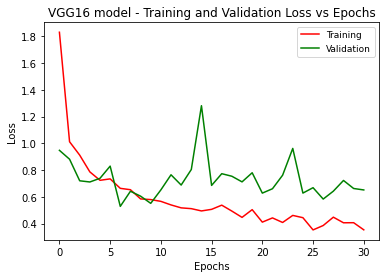

In [25]:
# Reference: https://stackoverflow.com/questions/36952763/how-to-return-history-of-validation-loss-in-keras
train_loss = vgg16_history.history['loss']
val_loss = vgg16_history.history['val_loss']
epochs = range(len(train_loss))

x = np.array(epochs)
y = np.array(train_loss)
plt.plot(x, y, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_loss)

plt.plot(x1, y1, 'g-', label = 'Validation')
plt.title('VGG16 model - Training and Validation Loss vs Epochs')
plt.legend(loc = 'upper right', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

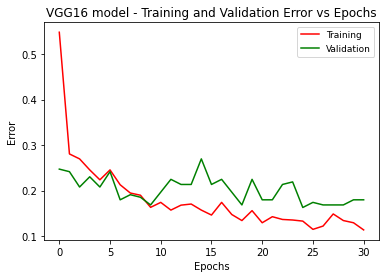

In [26]:
train_acc = vgg16_history.history['acc']
val_acc = vgg16_history.history['val_acc']
train_error = [1-i for i in train_acc]
val_error = [1-i for i in val_acc]
epochs = range(len(train_loss))

x = np.array(epochs)
y = np.array(train_error)
plt.plot(x, y, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_error)

plt.plot(x1, y1, 'g-', label = 'Validation')
plt.title('VGG16 model - Training and Validation Error vs Epochs')
plt.legend(loc = 'upper right', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.show()

In [15]:
vgg16_final_model.load_weights('/content/vgg_16.hdf5') 
pred = vgg16_final_model.predict(test_ds)
y_pred = pred.argmax(axis=-1)
y_test = test_ds.classes

35/35 [==============================] - 2s 58ms/step


In [17]:
# Reference: https://stackoverflow.com/questions/47706099/how-are-the-outputs-of-precision-recall-fscore-support-in-sklearn-ordered

from sklearn.metrics import precision_recall_fscore_support

accuracy = sum(y_test == y_pred) / len(y_test)
print("Accuracy: ", accuracy)

precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average=None)

for i in range(len(precision)):
    print("Class :", i)
    print(" * Precision: ", precision[i])
    print(" * Recall: ", recall[i])
    print(" * F1-score: ", f1_score[i])
    

Accuracy:  0.8070175438596491
Class : 0
 * Precision:  0.8333333333333334
 * Recall:  0.8333333333333334
 * F1-score:  0.8333333333333334
Class : 1
 * Precision:  0.7272727272727273
 * Recall:  0.8888888888888888
 * F1-score:  0.7999999999999999
Class : 2
 * Precision:  0.875
 * Recall:  0.875
 * F1-score:  0.875
Class : 3
 * Precision:  1.0
 * Recall:  0.75
 * F1-score:  0.8571428571428571
Class : 4
 * Precision:  0.6666666666666666
 * Recall:  0.6666666666666666
 * F1-score:  0.6666666666666666
Class : 5
 * Precision:  1.0
 * Recall:  0.6666666666666666
 * F1-score:  0.8
Class : 6
 * Precision:  1.0
 * Recall:  0.8888888888888888
 * F1-score:  0.9411764705882353
Class : 7
 * Precision:  0.7
 * Recall:  0.7777777777777778
 * F1-score:  0.7368421052631577
Class : 8
 * Precision:  0.7777777777777778
 * Recall:  0.7777777777777778
 * F1-score:  0.7777777777777778
Class : 9
 * Precision:  1.0
 * Recall:  0.8888888888888888
 * F1-score:  0.9411764705882353
Class : 10
 * Precision:  0.88888

EfficientNetB0 model

In [19]:
# Reference: https://keras.io/api/applications/efficientnet/
train_datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True,
    vertical_flip = True
)
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()
train_ds = train_datagen.flow_from_directory(
  "/content/drive/MyDrive/Data/train", 
  seed=1,
  target_size=(256, 256), #adjust to your needs
  batch_size=5,#adjust to your needs
  class_mode='categorical',
  subset='training'
)

validation_ds = val_datagen.flow_from_directory(
  "/content/drive/MyDrive/Data/val",
  target_size=(256,256),
  batch_size=5,
  class_mode='categorical'
)

test_ds = test_datagen.flow_from_directory(
    "/content/drive/MyDrive/Data/test",
  target_size=(256,256),
  batch_size=5,
  class_mode='categorical',
  shuffle=False
)

Found 827 images belonging to 20 classes.
Found 178 images belonging to 20 classes.
Found 171 images belonging to 20 classes.


In [20]:
# Reference: https://www.kaggle.com/code/lys620/efficientnet-with-keras

efmodel_model = EfficientNetB0(weights='imagenet', include_top=False)
for layers in efmodel_model.layers:
            layers.trainable=False
last_output = efmodel_model.layers[-1].output
efnet_x = tf.keras.layers.GlobalAveragePooling2D()(last_output)
efnet_x = tf.keras.layers.Dense(1024, activation='relu')(efnet_x)
efnet_x = tf.keras.layers.Dense(20, activation = 'softmax')(efnet_x)
efnet_final_model = Model(efmodel_model.input, efnet_x)
efnet_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

# EfficientNetB0
number_of_epochs = 50
efnet_filepath = 'efnet.hdf5'
efnet_checkpoint = tf.keras.callbacks.ModelCheckpoint(efnet_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
efnet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
efnet_history = efnet_final_model.fit(train_ds, epochs = number_of_epochs ,validation_data = validation_ds,callbacks=[efnet_checkpoint,efnet_early_stopping],verbose=1)

16705208/16705208 [==============================] - 1s 0us/step
Epoch 1/50
166/166 [==============================] - ETA: 0s - loss: 1.1635 - acc: 0.6385
Epoch 1: val_acc improved from -inf to 0.80337, saving model to efnet.hdf5
166/166 [==============================] - 27s 128ms/step - loss: 1.1635 - acc: 0.6385 - val_loss: 0.5994 - val_acc: 0.8034
Epoch 2/50
166/166 [==============================] - ETA: 0s - loss: 0.4196 - acc: 0.8694
Epoch 2: val_acc improved from 0.80337 to 0.88764, saving model to efnet.hdf5
166/166 [==============================] - 25s 153ms/step - loss: 0.4196 - acc: 0.8694 - val_loss: 0.3760 - val_acc: 0.8876
Epoch 3/50
166/166 [==============================] - ETA: 0s - loss: 0.2631 - acc: 0.9093
Epoch 3: val_acc did not improve from 0.88764
166/166 [==============================] - 20s 122ms/step - loss: 0.2631 - acc: 0.9093 - val_loss: 0.2999 - val_acc: 0.8820
Epoch 4/50
166/166 [==============================] - ETA: 0s - loss: 0.2480 - acc: 0.9178


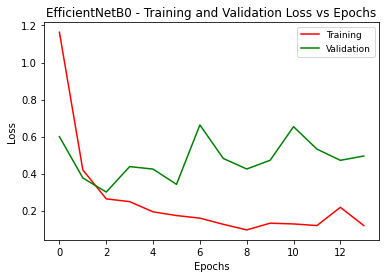

In [27]:
train_loss = efnet_history.history['loss']
val_loss = efnet_history.history['val_loss']
epochs = range(len(train_loss))

x = np.array(epochs)
y = np.array(train_loss)
plt.plot(x, y, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_loss)

plt.plot(x1, y1, 'g-', label = 'Validation')
plt.title('EfficientNetB0 - Training and Validation Loss vs Epochs')
plt.legend(loc = 'upper right', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

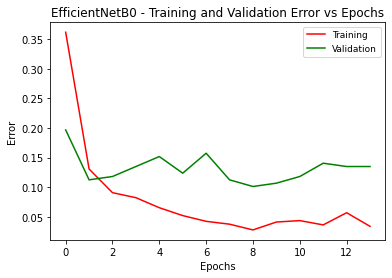

In [28]:
train_acc = efnet_history.history['acc']
val_acc = efnet_history.history['val_acc']
train_error = [1-i for i in train_acc]
val_error = [1-i for i in val_acc]
epochs = range(len(train_loss))

x = np.array(epochs)
y = np.array(train_error)
plt.plot(x, y, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_error)

plt.plot(x1, y1, 'g-', label = 'Validation')
plt.title('EfficientNetB0 - Training and Validation Error vs Epochs')
plt.legend(loc = 'upper right', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.show()

In [23]:
efnet_final_model.load_weights('/content/efnet.hdf5') 
pred = efnet_final_model.predict(test_ds)
y_pred = pred.argmax(axis=-1)
y_test = test_ds.classes

35/35 [==============================] - 3s 48ms/step


In [24]:
from sklearn.metrics import precision_recall_fscore_support

accuracy = sum(y_test == y_pred) / len(y_test)
print("Accuracy: ", accuracy)

precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average=None)

for i in range(len(precision)):
    print("Class :", i)
    print(" * Precision: ", precision[i])
    print(" * Recall: ", recall[i])
    print(" * F1-score: ", f1_score[i])

Accuracy:  0.9122807017543859
Class : 0
 * Precision:  1.0
 * Recall:  1.0
 * F1-score:  1.0
Class : 1
 * Precision:  1.0
 * Recall:  0.8888888888888888
 * F1-score:  0.9411764705882353
Class : 2
 * Precision:  1.0
 * Recall:  1.0
 * F1-score:  1.0
Class : 3
 * Precision:  1.0
 * Recall:  1.0
 * F1-score:  1.0
Class : 4
 * Precision:  0.875
 * Recall:  0.7777777777777778
 * F1-score:  0.823529411764706
Class : 5
 * Precision:  1.0
 * Recall:  0.8888888888888888
 * F1-score:  0.9411764705882353
Class : 6
 * Precision:  1.0
 * Recall:  1.0
 * F1-score:  1.0
Class : 7
 * Precision:  1.0
 * Recall:  0.6666666666666666
 * F1-score:  0.8
Class : 8
 * Precision:  0.8181818181818182
 * Recall:  1.0
 * F1-score:  0.9
Class : 9
 * Precision:  1.0
 * Recall:  1.0
 * F1-score:  1.0
Class : 10
 * Precision:  1.0
 * Recall:  1.0
 * F1-score:  1.0
Class : 11
 * Precision:  1.0
 * Recall:  1.0
 * F1-score:  1.0
Class : 12
 * Precision:  0.9
 * Recall:  1.0
 * F1-score:  0.9473684210526316
Class : 13
 